In [2]:
import numpy as np
import pandas as pd
import cv2
import requests
import json
from datetime import datetime
from tensorflow.keras import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

In [4]:
for feature, label in dataset['train'].take(3):
    print(feature.shape)

(500, 667, 3)
(500, 666, 3)
(670, 500, 3)


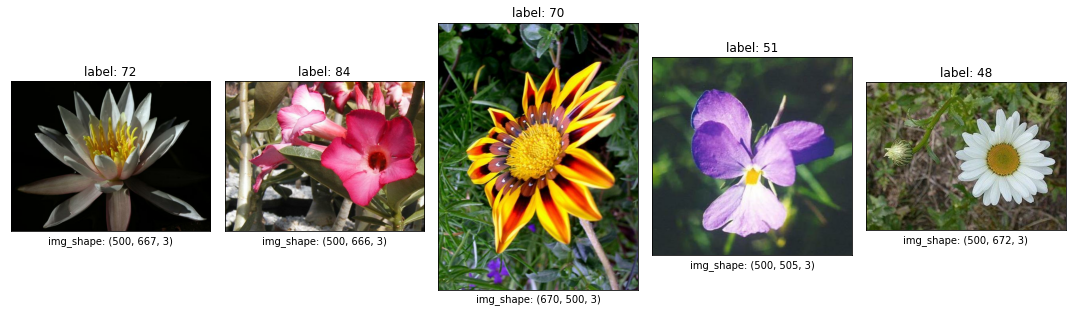

In [5]:
fig = plt.figure(figsize=(15,15))
i=0
for image, label in dataset['train'].take(5):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.xlabel(f"img_shape: {image.shape}")
    i=i+1;
fig.tight_layout()

In [6]:
print(f"Number of training data points: {dataset_info.splits['train'].num_examples}")
print(f"Number of testing data points: {dataset_info.splits['test'].num_examples}")
print(f"Number of validation data points: {dataset_info.splits['validation'].num_examples}")
no_classes = dataset_info.features['label'].num_classes
print(f"Number of classes: {no_classes}")

Number of training data points: 1020
Number of testing data points: 6149
Number of validation data points: 1020
Number of classes: 102


In [7]:
file_location='https://github.com/mozarik/pembelajaran-mesin/blob/iqlima/label_map.json?raw=1'
r = requests.get(file_location, stream=True)
class_names = json.loads(r.content.decode('utf-8'))
class_names = {int(k):v for k,v in class_names.items()}

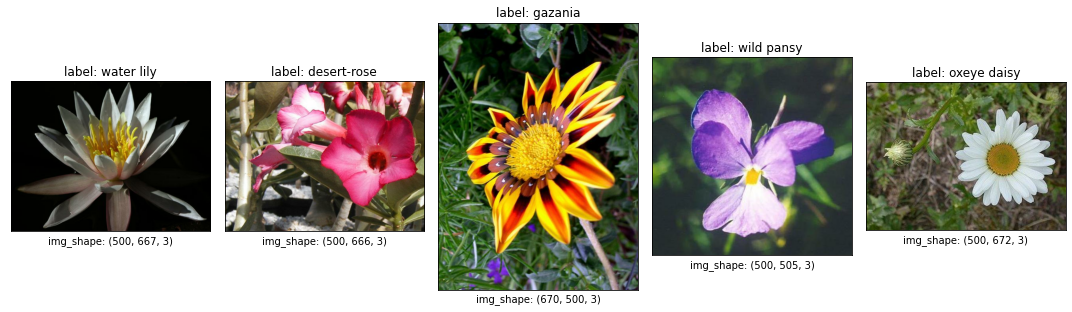

In [8]:
fig = plt.figure(figsize=(15,15))
i=0
for image, label in dataset['train'].take(5):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.imshow(image)
    plt.title(f"label: {class_names[label.numpy()+1]}")
    plt.xlabel(f"img_shape: {image.shape}")
    i=i+1;
fig.tight_layout()

In [9]:
def resize_image(image, size=(224,224)):
    return tf.image.resize(image, size)

In [10]:
def normalize_image(images, a=-1, b=1, minPix=[0], maxPix=[255]):
  
    a = tf.constant([a], dtype=tf.float32)
    b = tf.constant([b], dtype=tf.float32)
    min_pixel = tf.constant(minPix, dtype=tf.float32)
    max_pixel = tf.constant(maxPix, dtype=tf.float32)

    return a + (((images - min_pixel)*(b - a) )/(max_pixel - min_pixel))

In [11]:
def oneHotEncode(labels, no_classes):
    return tf.one_hot(labels, no_classes)

In [12]:
def flip(x):

    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [13]:
def rotate(x):
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [14]:
def _preprocess_data(*vals):
  
    features = normalize_image(resize_image(vals[0]))
    labels = oneHotEncode(vals[1], no_classes)
    return features, labels

In [15]:
def _preprocess_data_augmentation(*vals):

    features = rotate(flip(normalize_image(resize_image(vals[0]))))
    labels = oneHotEncode(vals[1], no_classes)
    return features, labels

In [16]:
batch_size = 128
buffer_size = 500
train_set = dataset['train'].shuffle(buffer_size).map(_preprocess_data_augmentation).batch(batch_size) 
test_set = dataset['test'].map(_preprocess_data).batch(batch_size) 
validation_set = dataset['validation'].map(_preprocess_data).batch(batch_size)

In [17]:
print(f"training set shape: {np.array(list(train_set)).shape}")
print(f"testing set shape: {np.array(list(test_set)).shape}")
print(f"validation set shape: {np.array(list(validation_set)).shape}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


training set shape: (8, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


testing set shape: (49, 2)
validation set shape: (8, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Activation("relu"))
model.add(layers.Dense(102))
model.add(layers.Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)              

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_set,
                    epochs=25,
                    validation_data=validation_set,
                    callbacks=[early_stopping])

Epoch 1/25
8/8 [==============================] - 114s 14s/step - loss: 4.6669 - accuracy: 0.0078 - val_loss: 4.6121 - val_accuracy: 0.0255
Epoch 2/25
8/8 [==============================] - 122s 16s/step - loss: 4.6184 - accuracy: 0.0098 - val_loss: 4.5965 - val_accuracy: 0.0343
Epoch 3/25
8/8 [==============================] - 122s 16s/step - loss: 4.5951 - accuracy: 0.0157 - val_loss: 4.5622 - val_accuracy: 0.0402
Epoch 4/25
8/8 [==============================] - 122s 16s/step - loss: 4.5530 - accuracy: 0.0275 - val_loss: 4.4898 - val_accuracy: 0.0363
Epoch 5/25
8/8 [==============================] - 123s 16s/step - loss: 4.4765 - accuracy: 0.0245 - val_loss: 4.3746 - val_accuracy: 0.0402
Epoch 6/25
8/8 [==============================] - 121s 15s/step - loss: 4.3844 - accuracy: 0.0304 - val_loss: 4.2407 - val_accuracy: 0.0598
Epoch 7/25
8/8 [==============================] - 122s 16s/step - loss: 4.2923 - accuracy: 0.0500 - val_loss: 4.1067 - val_accuracy: 0.0706
Epoch 8/25
8/8 [====

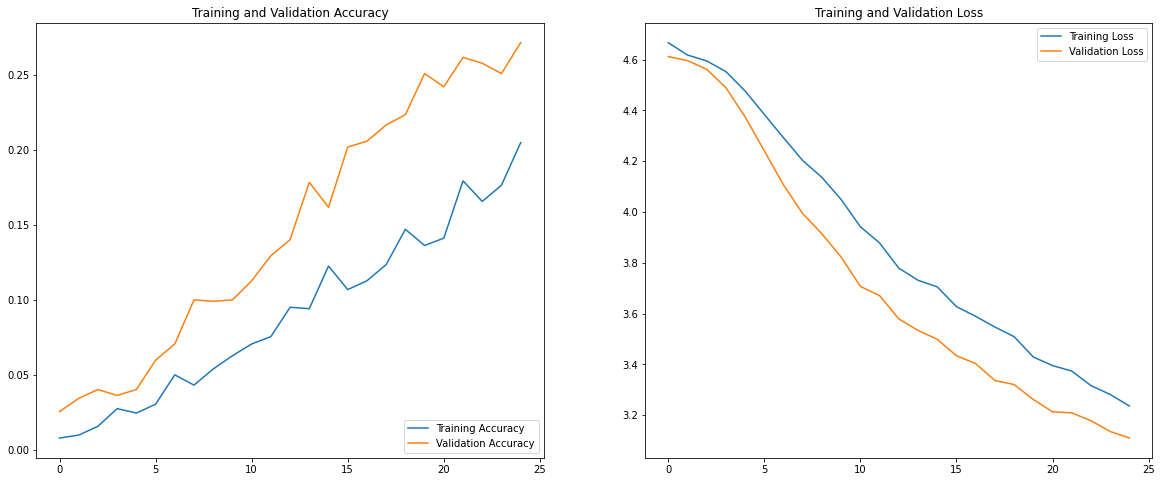

In [28]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(Epochs)
epochs_range = range(25)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
result=model.evaluate(test_set)
print(f"test loss: {result[0]}, test accuracy: {result[1]}")

49/49 [==============================] - 160s 3s/step - loss: 3.2815 - accuracy: 0.2487
test loss: 3.28145170211792, test accuracy: 0.24865831434726715


In [30]:
today = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")
saved_model_path = f"./saved_models/checkpoint_{today}"
model.save(saved_model_path, save_format='h5')
print(f"Model saved at: {saved_model_path}")

Model saved at: ./saved_models/checkpoint_02_11_2021__10_26_23
